# Curvas de Accuracy y Mean Distance

En esta notebook, veremos de armar las curvas de geolocalización y mean distance. 

Es decir, para cada modelo entrenado, vamos a ver cuál fue su performance usando las primeras 250, 500, 750, ... , 18.5, 19k, 19.5k palabras (~20% del vocabulario). La performance la vamos a medir de dos maneras:

1. Accuracy (recordemos que es un problema con 23 clases)
2. Mean Distance: la media del error en las distancias. Acá fijamos la distancia entre dos provincias como la distancia entre sus capitales 

El modelo lo entrenamos con MaxEnt/Regresión Logística usando penalidad $L_2$ y $C=1$. Los sets de features son los siguientes: 

1. Information Value sobre palabras
2. Information Value sobre personas 
3. Information Gain Ratio (Han, Cook et al) sobre palabras
4. Information Gain Ratio sobre personas
5. Ordenados por Cantidad de provincias, luego por term-frequency (term-frequency inverse-province frequency, TF-IPF)


Cargamos los resultados ya calculados

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import seaborn as sns

dfs = {}

dfs["igr_palabras"] = pd.DataFrame(
    pickle.load(open("res_igr_palabras.pkl", "rb"))
)
dfs["igr_personas"] = pd.DataFrame(
    pickle.load(open("res_igr_personas.pkl", "rb"))
)
dfs["iv_palabras"] = pd.DataFrame(
    pickle.load(open("res_iv_palabras.pkl", "rb")) 
)
dfs["iv_personas"] = pd.DataFrame(
    pickle.load(open("res_iv_personas.pkl", "rb"))
)
dfs["tf_ipf"] = pd.DataFrame(
    pickle.load(open("res_tf_ipf.pkl", "rb"))
)

for key, df in dfs.items():
    df.set_index("num_words", inplace=True)
    df.drop("clf", axis=1, inplace=True)

Hago join de todo esto para poder graficarlo

In [2]:
joined = dfs["igr_palabras"].join(dfs["igr_personas"], lsuffix="_igr_palabras", rsuffix="_igr_personas")
joined = joined.join(dfs["iv_palabras"])
joined = joined.join(dfs["iv_personas"], lsuffix="_iv_palabras", rsuffix="_iv_personas")

joined["accuracy_tf_ipf"] = dfs["tf_ipf"]["accuracy"]
joined["mean_distance_tf_ipf"] = dfs["tf_ipf"]["mean_distance"]


In [3]:
joined.columns

Index(['accuracy_igr_palabras', 'mean_distance_igr_palabras',
       'accuracy_igr_personas', 'mean_distance_igr_personas',
       'accuracy_iv_palabras', 'mean_distance_iv_palabras',
       'accuracy_iv_personas', 'mean_distance_iv_personas', 'accuracy_tf_ipf',
       'mean_distance_tf_ipf'],
      dtype='object')

In [4]:
from contrastes.processing import build_dataframe_from_users
from contrastes.processing import preprocess_raw_df

word_df = pd.read_csv("train_word_df_filtered.csv", index_col=0)
word_df = preprocess_raw_df(word_df, filter_words=(10, 2))

/home/jmperez/projects/contrastes/contrastes/processing.py:185: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_palabras = cant_palabras
/home/jmperez/projects/contrastes/contrastes/processing.py:186: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_personas = cant_personas


In [5]:
word_df.shape

(103782, 55)

## Gráfico de accuracy según cantidad de features usadas

Acá haremos un gráfico de la accuracy (más accuracy es mejor!)

In [6]:
def rename_column(col_name):
    col_name = col_name.replace("mean_distance_", "")
    col_name = col_name.replace("accuracy_", "")
    col_name = col_name.replace("igr_palabras", "igr")
    col_name = col_name.replace("igr_personas", "igr users")
    col_name = col_name.replace("iv_palabras", "ltf-ig")
    col_name = col_name.replace("iv_personas", "luf-ig")
    col_name = col_name.replace("tf_ipf", "tf-ilf")
    return col_name

In [7]:
joined

,accuracy_igr_palabras,mean_distance_igr_palabras,accuracy_igr_personas,mean_distance_igr_personas,accuracy_iv_palabras,mean_distance_iv_palabras,accuracy_iv_personas,mean_distance_iv_personas,accuracy_tf_ipf,mean_distance_tf_ipf
num_words,,,,,,,,,,
250,0.4292,588.8424,0.3616,632.0648,0.6188,289.0256,0.5948,306.7484,0.2512,750.3752
500,0.5228,495.3980,0.4460,542.0792,0.6740,257.8760,0.6724,253.0200,0.3192,676.3920
750,0.5824,424.1440,0.5080,492.4676,0.7040,242.1412,0.6960,232.4720,0.3524,643.9780
1000,0.6196,330.2300,0.5564,436.9324,0.7072,257.8824,0.7196,245.7480,0.3856,614.0620
1250,0.6328,320.6816,0.6016,393.7628,0.6980,260.0136,0.7380,228.4808,0.4424,568.6348
1500,0.6500,275.7196,0.6232,376.7876,0.7028,254.8560,0.7472,218.8384,0.4932,516.4276
1750,0.6636,264.9508,0.6416,356.9404,0.7200,256.0508,0.7620,207.0176,0.5192,496.7968
2000,0.6744,257.8484,0.6740,316.8856,0.7224,255.2300,0.7628,203.7484,0.5300,484.1520
2250,0.6752,258.6624,0.6924,314.4144,0.7196,261.6268,0.7612,186.1324,0.5372,475.3536


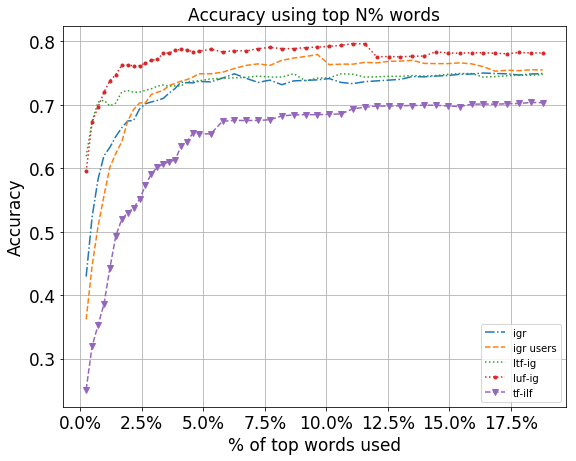

In [20]:
import matplotlib.pyplot as plt

cols = [col for col in joined.columns if "accuracy" in col]
acc_df = joined[cols].copy()

rename = {col: rename_column(col) for col in cols}
acc_df.rename(rename, axis=1, inplace=True)

fontsize = 17

markers = ["-.", "--", ":", ":.", "--v"]
x = (100 * joined.index / word_df.shape[0])

ax = acc_df.plot(
    x=x,
    title="Accuracy using top words", figsize=(9, 7), grid=True,
    style=markers, fontsize=fontsize
);

ax.set_title("Accuracy using top N% words", fontsize=fontsize)
ax.set_xlabel("% of top words used", fontsize=fontsize)
ax.set_ylabel("Accuracy", fontsize=fontsize)
ax.set_xticklabels([str(t)+"%" for t in ax.get_xticks()]);

plt.savefig("../../output/figures/accuracy_comparison.png")

- Nuestra métrica anda bastante mejor que las demás
- En ambos casos, usando un poco más del 2% de las palabras anda mejor la de usuarios
- Cuantas más palabras usemos, obvio que todas las métricas tienden a "converger" 
- Muchísimo mejor que el baseline

## Gráfico de Mean Distance según cantidad de features usadas

Acá haremos un gráfico de la mean distance (menos es mejor!)

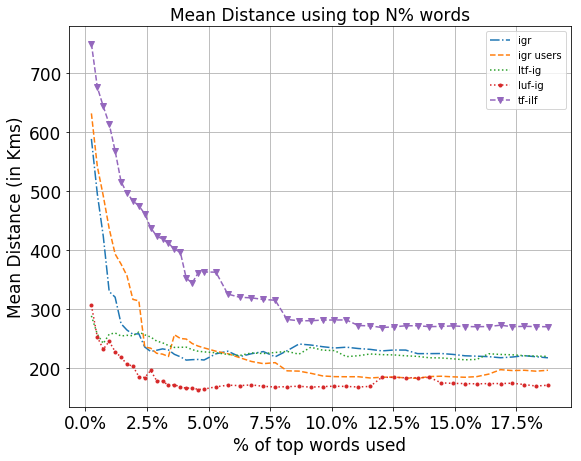

In [22]:
import matplotlib.pyplot as plt

cols = [col for col in joined.columns if "mean_distance" in col]
md_df = joined[cols].copy()

rename = {col: rename_column(col) for col in cols}
md_df.rename(rename, axis=1, inplace=True)


markers = ["-.", "--", ":", ":.", "--v"]
x = (100 * joined.index / word_df.shape[0])

ax = md_df.plot(
    x=x,
    title="Mean Distance using top words", figsize=(9, 7), grid=True,
    style=markers, fontsize=fontsize,
);

ax.set_title("Mean Distance using top N% words", fontsize=fontsize)
ax.set_xlabel("% of top words used", fontsize=fontsize)
ax.set_ylabel("Mean Distance (in Kms)", fontsize=fontsize)
ax.set_xticklabels([str(t)+"%" for t in ax.get_xticks()]);

plt.savefig("../../output/figures/mean_distance_comparison.png")

- Acá es mucho más claro que anda mejor nuestra métrica. 
- La IGR de usuarios no anda mejor necesariamente que la IGR words


## Tabla de resultados

In [10]:
res_df = pd.DataFrame({"Accuracy": acc_df.loc[5000], "Mean Distance": md_df.loc[5000]})
res_df = res_df.append(pd.Series({"Accuracy": 0.38, "Mean Distance": 600}, name="baseline"))

res_df

,Accuracy,Mean Distance
igr,0.7368,214.2028
igr users,0.7488,234.7164
ltf-ig,0.7376,227.9684
luf-ig,0.7840,164.8808
tf-ilf,0.6544,363.3788
baseline,0.3800,600.0000


In [11]:
print(res_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Accuracy &  Mean Distance \\
\midrule
igr       &    0.7368 &       214.2028 \\
igr users &    0.7488 &       234.7164 \\
ltf-ig    &    0.7376 &       227.9684 \\
luf-ig    &    0.7840 &       164.8808 \\
tf-ilf    &    0.6544 &       363.3788 \\
baseline  &    0.3800 &       600.0000 \\
\bottomrule
\end{tabular}

